# setup

In [1]:
import os

sep = '\\'
if os.getcwd().split(sep)[-1] == 'notebooks':
    os.chdir('..')
    print(os.getcwd())
assert os.getcwd().split(sep)[-1] == 'vashisth2022direct'

c:\Users\katri\Downloads\git\petrobras\vashisth2022direct


In [2]:
import pathlib
import matplotlib.pyplot as plt
import lasio
import numpy as np
import tensorflow as tf
import pandas as pd
import math

from scipy import signal
from segysak.segy import segy_loader
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from tensorflow.python.keras import initializers, optimizers
from tensorflow.python.keras.layers import Input, Dense, Activation, Flatten, Conv2D, Dropout, Layer
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# utils

In [3]:
def RC_fwd_model_ia(ia1, ia2):
    Rpp = (ia2 - ia1) / (ia2 + ia1)
    return Rpp

In [4]:
#Ordem de inputs da funcao: 1 - profundidade, 2- curva de poco que deseja filtrar parta a escala sismica, 3 -dado sismico 3D
#4- ponto mais raso em profundidade (equivalente ao corte inicial do dado sismico),
#5- ponto mais profundo(equivalente ao corte final do dado sismico)
def escala_sismica(depth,curva_poco,dado_sismico,depth_point1,depth_point2): 
    wells=[]
    
    wells.append(np.array([depth,curva_poco]).T)
    #print(wells)
    npocos = 1
    avgParam = 1 #parameter used for
    upperLimit = depth_point2#intersection of points
    lowerLimit = depth_point1
    columns = [] 
    jumpvec =[]
    inivec = np.zeros(npocos)
    endvec = np.zeros(npocos)
    dzi = np.zeros(npocos)
    indw = 0
    
    for well in wells:
        depthX = 0
        dzi[indw] = well[3,0] -well[2,0]
        ini, end = -1, -1
        for i in range(well.shape[0]):
            if well[i, 0] >= lowerLimit and well[i, 0] <= upperLimit:
                depthX += 1
                if ini == -1:
                    ini = i
            elif ini != -1:
                end = i-1
                break
        if end == -1:# in case is the whole well
            end = well.shape[0]-1
        jump = (depthX-1)/(dado_sismico.shape[2])
        
        inivec[indw] = ini
        endvec[indw] = end
        indw +=1
    
        jumpvec.append([math.floor(jump)])
        columns.append([math.floor(ini + j*jump) for j in range(dado_sismico.shape[2]+1)])
    
    jumpvec =np.array(jumpvec)

    wellsF =[]
    for i in range(len(wells)):
        auxWell = []
        #print(np.shape(inivec))
    
        # cria dados de poco com filtro
        auxWellF = []
    
        a = math.floor(inivec[i])

        #vetores com dados originais do poco selecionados na faixa de 200m
        auxcurva = wells[i][math.floor(inivec[i]):math.floor(endvec[i]),1]
        
        # escala dos dados sismicos em metros
        lb = 5
        #escala do poco i e'  dada por   (200/(endvec[i] - inivec[i]))
        ep =(200/(endvec[i] - inivec[i]))

        Timepoco  = np.arange(np.shape(auxcurva)[0])

        vpmedio = 4.865042027693202 #km/s
        dti = 2 * dzi[i]  / (1000 * vpmedio)   # dzi[i]  passo de profundidade poco poco i em metros
        Timepoco = Timepoco * dti
        nfiltp  = 3
        #60 na linha abaixo  corresponde 60 Hertz que define o corte no filtro (frequencias acima de 60 são cortadas)
        cutofffrp =  2 * 60 * dti
        #print(dti,cutofffrp)
        bp, ap = signal.butter(nfiltp, cutofffrp)
        curvafilt = signal.filtfilt(bp, ap, np.squeeze(auxcurva))
        
        for j in range((dado_sismico.shape[2])):

            curvaiF = curvafilt[j*jumpvec[i]]

            auxWellF.append([curvaiF])
        
        j = (dado_sismico.shape[2]) 
        curvaiF = curvafilt[j*jumpvec[i]-1]
        auxWellF.append([curvaiF])
    
        wellsF.append(auxWellF)

        wellsF[i] = np.array(auxWellF)

    wells = np.array(wellsF)
    return wells[0,:,0,0]

# poço

In [5]:
def porosity_calc(rho_b, rho_ma, rho_f):
    rho_n = np.array(rho_b)
    phi_calc = np.zeros(rho_n.size)
    for i in range(rho_n.size):
        phi_calc[i] = ((rho_n[i] - rho_ma) / (rho_f-rho_ma))*100

    return phi_calc

In [6]:
# well1 = lasio.read('7buz12rjs_editadas.las')
# well2 = lasio.read('7-buz-14da-rjs_curvas_basicas.las')
well3 = lasio.read('data/dados/7buz23rjs.las')
# well4 = lasio.read('7-buz-25-rjs_curvas_basicas.las')
well5 = lasio.read('data/dados/7-buz-29-rjs.las')
# well6 = lasio.read('7-buz-31d-rjs_curvas_basicas.las')
# well7 = lasio.read('8-BUZ-21D-RJS_editadas.las')
well8 = lasio.read('data/dados/8-buz-26-rjs.las')
# well9 = lasio.read('data/dados/8buz28da.las')
# well10 = lasio.read('8-buz-32da-rjs_curvas_basicas.las')
# well11 = lasio.read('8buz15rjs_edit.las')
well12 = lasio.read('data/dados/8buz20rjs.las')
# well13 = lasio.read('3-BRSA-1184-RJS-las.las')
well14 = lasio.read('data/dados/7-buz-10-rjs.las')
# well15 = lasio.read('7-BUZ-30-RJS-las.las')
# well16 = lasio.read('8-BUZ-9-RJS-las.las')
# well20 = lasio.read('9-BRSA-1191-RJS-las.las') #converter nphi para porcentagem
# well18 = lasio.read('9-BUZ-4-RJS-las.las')
# well19 = lasio.read('9-BUZ-8-RJS-las.las')

##
# well17 = lasio.read('9-BRSA-1197-RJS-las.las') #Utilizar para gerar figura, converter nphi para porcentagem
well18 = lasio.read('data/dados/3-brsa-1053-rjs.las')

In [7]:
well3_df = well3.df().dropna(how = 'any', axis=0)
well5_df = well5.df().dropna(how = 'any', axis=0)
well8_df = well8.df().dropna(how = 'any', axis=0)
well12_df = well12.df().dropna(how = 'any', axis=0)
well14_df = well14.df().dropna(how = 'any', axis=0)
well18_df = well18.df().dropna(how = 'any', axis=0)

In [8]:
data3 = well3_df
res3 = np.array(data3['BRRESP'])[+150:]
rho3 = np.array(data3['BRDENS'])[+150:]
dtp3 = np.array(data3['BRDTP'])[+150:]
dts3 = np.array(data3['BRDTS'])[+150:]
phi3 = np.array(data3['BRNEUT'])[+150:] / 100
gr3 = np.array(data3['BRGR'])[+150:]
z3 = data3.index[+150:]

vp3 = (10**3/dtp3)*0.3048 #km/s
vs3 = (10**3/dts3)*0.3048 #km/s

phi_den3 = porosity_calc(rho3,2.8,1.05)

twt3 = np.array(data3['TWT'])[+150:]
dpt3 = np.array(data3['DEPT'])[+150:]

In [9]:
data5 = well5_df
# res5 = np.array(data5['BRRESP'])[+150:]
res5 = np.array(data5['BRRESP'])
rho5 = np.array(data5['BRDENS']) #g/cm3
dtp5 = np.array(data5['BRDTP'])
phi5 = np.array(data5['BRNEUT']) / 100
gr5 = np.array(data5['BRGR'])
z5 = data5.first_valid_index

vp5 = (10**3/dtp5)*0.3048 #km/s

phi_den5 = porosity_calc(rho5,2.8,1.05)

twt5 = np.array(data5['TWT'])
# dpt5 = np.array(data5['DEPT'])[+150:]
dpt5 = np.array(data5['TVD'])

In [10]:
data8 = well8_df
res8 = np.array(data8['BRRESP'])[+14200:]
rho8 = np.array(data8['BRDENS'])[+14200:]
dtp8 = np.array(data8['BRDTP'])[+14200:]
phi8 = np.array(data8['BRNEUT'])[+14200:] / 100
gr8 = np.array(data8['BRGR'])[+14200:]
z8 = data8.index[+14200:]

vp8 = (10**3/dtp8)*0.3048 #km/s

phi_den8 = porosity_calc(rho8,2.8,1.05)

twt8 = np.array(data8['TWT'])[+14200:]

In [11]:
data12 = well12_df
res12 = np.array(data12['BRRESP'])
rho12 = np.array(data12['BRDENS'])
dtp12 = np.array(data12['BRDTP'])
phi12 = np.array(data12['BRNEUT']) / 100
gr12 = np.array(data12['BRGR'])
z12 = data12.index

vp12 = (10**3/dtp12)*0.3048 #km/s

phi_den12 = porosity_calc(rho12,2.8,1.05)

twt12 = np.array(data12['TWT'])

In [12]:
data14 = well14_df
res14 = np.array(data14['RT90'])
rho14 = np.array(data14['RHOB'])
dtp14 = np.array(data14['DT'])
phi14 = np.array(data14['NPHI']) / 100
gr14 = np.array(data14['GR'])
z14 = data14.index

vp14 = (10**3/dtp14)*0.3048 #km/s

phi_den14 = porosity_calc(rho14,2.8,1.05)

twt14 = np.array(data14['TWT'])

In [13]:
data18 = well18_df
res18 = np.array(data18['BRRESP'])
rho18 = np.array(data18['BRDENS'])
dtp18 = np.array(data18['BRDTP'])
phi18 = np.array(data18['BRNEUT'])
gr18 = np.array(data18['BRGR'])
z18 = data18.index

vp18 = (10**3/dtp18)*0.3048 #km/s

phi_den18 = porosity_calc(rho18,2.8,1.05)

twt18 = np.array(data18['TWT'])

# regressao

In [14]:
depth_point1 = 4898
depth_point2 = 5092
depth_point1true = 4948
depth_point2true = 5040

idx3 = (twt3 > depth_point1true) * (twt3 < depth_point2true)
idx5 = (twt5 > depth_point1true) * (twt5 < depth_point2true)
idx8 = (twt8 > depth_point1true) * (twt8 < depth_point2true)
idx12 = (twt12 > depth_point1true) * (twt12 < depth_point2true)
idx14 = (twt14 > depth_point1true) * (twt14 < depth_point2true)
idx18 = (twt18 > depth_point1true) * (twt18 < depth_point2true)

In [15]:
array3 = np.array([phi3[idx3]]).T
array5 = np.array([phi5[idx5]]).T
array8 = np.array([phi8[idx8]]).T
array12 = np.array([phi12[idx12]]).T
array14 = np.array([phi14[idx14]]).T
array18 = np.array([phi18[idx18]]).T

imp3 = vp3 * rho3
y3 = imp3[idx3]
imp5 = vp5 * rho5
y5 = imp5[idx5]
imp8 = vp8 * rho8
y8 = imp8[idx8]
imp12 = vp12 * rho12
y12 = imp12[idx12]
imp14 = vp14 * rho14
y14 = imp14[idx14]
imp18 = vp18 * rho18
y18 = imp18[idx18]

x_data = np.concatenate([array3, array5, array8, array12, array14, array18])
y_data = np.concatenate([y3, y5, y8, y12, y14, y18])

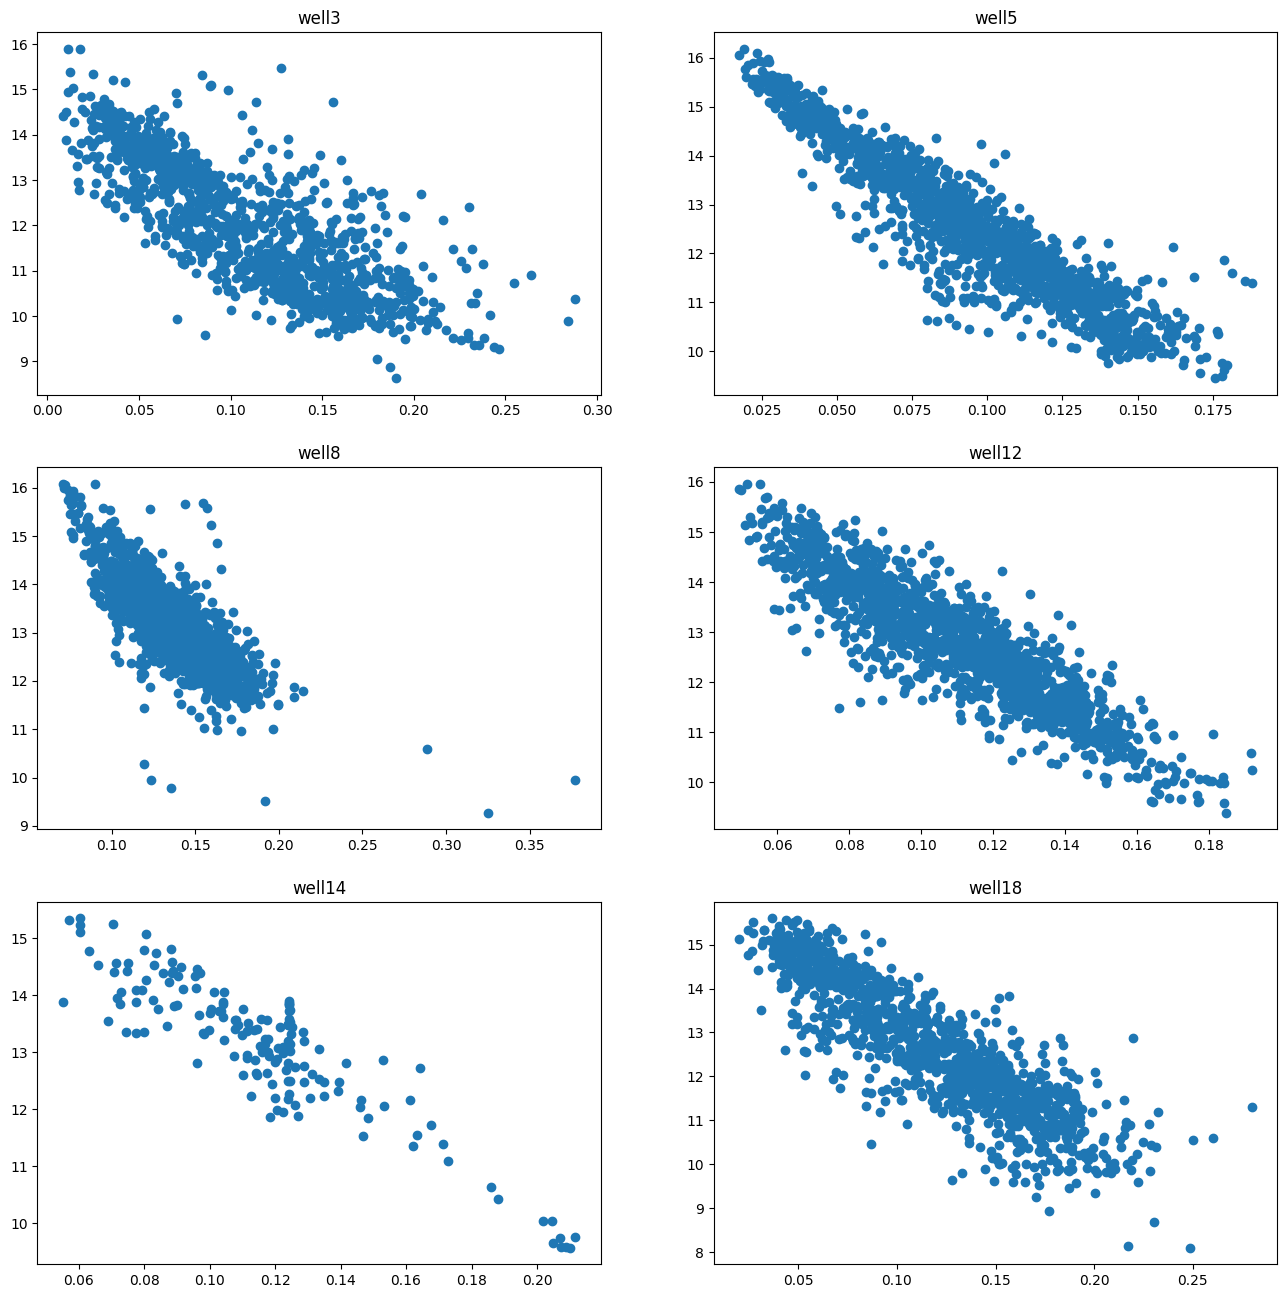

In [16]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 16))

axes[0, 0].scatter(array3, y3);
axes[0, 1].scatter(array5, y5);
axes[1, 0].scatter(array8, y8);
axes[1, 1].scatter(array12, y12);
axes[2, 0].scatter(array14, y14);
axes[2, 1].scatter(array18, y18);
# axes[3, 1].scatter(x_data, y_data);

col1 = [3, 8, 14]
col2 = [5, 12, 18]
[ax[0].set_title('well{}'.format(col1[idx])) for idx, ax in enumerate(axes)];
[ax[1].set_title('well{}'.format(col2[idx])) for idx, ax in enumerate(axes)];

In [17]:
regr_lr3 = LinearRegression().fit(array3, y3)
regr_lr5 = LinearRegression().fit(array5, y5)
regr_lr8 = LinearRegression().fit(array8, y8)
regr_lr12 = LinearRegression().fit(array12, y12)
regr_lr14 = LinearRegression().fit(array14, y14)
regr_lr18 = LinearRegression().fit(array18, y18)

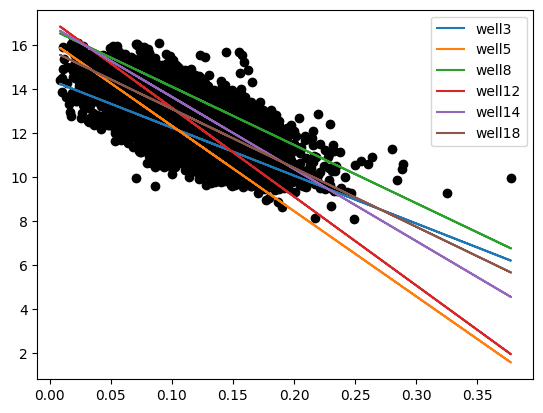

In [18]:
plt.scatter(x_data, y_data, color = 'black');

plt.plot(x_data, regr_lr3.predict(x_data), label = 'well3');
plt.plot(x_data, regr_lr5.predict(x_data), label = 'well5');
plt.plot(x_data, regr_lr8.predict(x_data), label = 'well8');
plt.plot(x_data, regr_lr12.predict(x_data), label = 'well12');
plt.plot(x_data, regr_lr14.predict(x_data), label = 'well14');
plt.plot(x_data, regr_lr18.predict(x_data), label = 'well18');

plt.legend();

In [19]:
x_trn = np.concatenate([array3, array5, array8, array14, array18])
y_trn = np.concatenate([y3, y5, y8, y14, y18])
regr_lr = LinearRegression().fit(x_trn, y_trn)

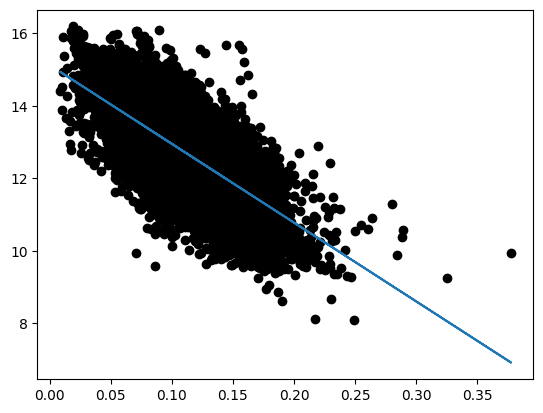

In [20]:
plt.scatter(x_data, y_data, color = 'black');
plt.plot(x_data, regr_lr.predict(x_data));

In [21]:
regr_lr.coef_, regr_lr.intercept_

(array([-21.72093889]), 15.12500910727761)

# sismica

In [22]:
V3D_path = pathlib.Path("data/buzios_corte_tempo_ext.sgy")
# V3D_path = pathlib.Path("../datasets/ffb/Area_Teste_Interpretabilidade_10-04-24.sgy")
print("3D", V3D_path, V3D_path.exists())

3D data\buzios_corte_tempo_ext.sgy True


In [23]:
V3D = segy_loader(V3D_path, iline=189, xline=193, vert_domain="TWT")
V3D

100%|██████████| 69.7k/69.7k [00:09<00:00, 7.63k traces/s]


Loading as 3D
Fast direction is INLINE_3D


Converting SEGY: 100%|██████████| 69.7k/69.7k [00:38<00:00, 1.83k traces/s]


<xarray.Dataset>
Dimensions:  (iline: 176, xline: 399, twt: 49)
Coordinates:
  * iline    (iline) uint16 4000 4001 4002 4003 4004 ... 4172 4173 4174 4175
  * xline    (xline) uint16 2200 2201 2202 2203 2204 ... 2597 2598 2599 2600
  * twt      (twt) float64 4.898e+03 4.902e+03 4.906e+03 ... 5.086e+03 5.09e+03
Data variables:
    data     (iline, xline, twt) float32 -0.1251 -0.5392 ... -0.4145 -0.4634
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 3D VOLUME\nC 2 HEADER BYTE LOCATIONS AND TYPES:\...
    measurement_system:  0
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         buzios_corte_tempo_ext.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-1.8118953313540063, -1.8024231615736244, -1.103852...
    coord_scalar:        -10.0

In [24]:
coord3 = [4131, 2572]
coord5 = [4075, 2472]
coord8 = [4102, 2360]
coord12 = [4168, 2525]
coord14 = [4065, 2492]
coord18 = [4114, 2500]

In [25]:
sismica3 = V3D.data.sel(iline = coord3[0], xline = coord3[1]).data
sismica5 = V3D.data.sel(iline = coord5[0], xline = coord5[1]).data
sismica8 = V3D.data.sel(iline = coord8[0], xline = coord8[1]).data
sismica12 = V3D.data.sel(iline = coord12[0], xline = coord12[1]).data
sismica14 = V3D.data.sel(iline = coord14[0], xline = coord14[1]).data
sismica18 = V3D.data.sel(iline = coord18[0], xline = coord18[1]).data

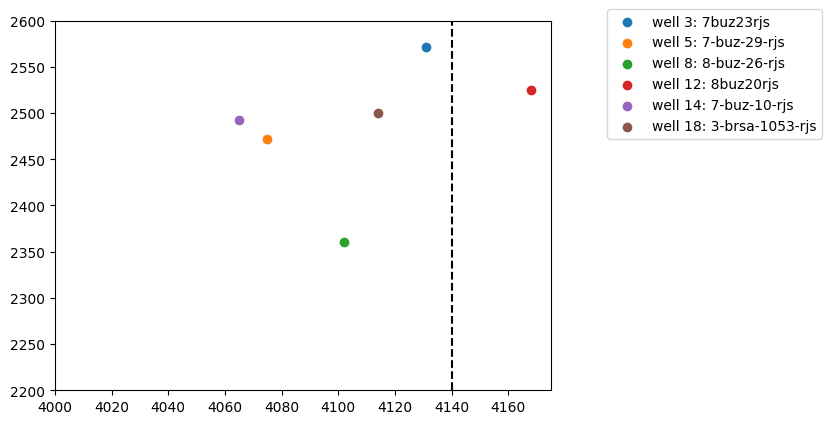

In [26]:
split = 140

wells = ['3: 7buz23rjs', '5: 7-buz-29-rjs', '8: 8-buz-26-rjs', 
         '12: 8buz20rjs', '14: 7-buz-10-rjs', '18: 3-brsa-1053-rjs']
for idx, coord in enumerate([coord3, coord5, coord8, coord12, coord14, coord18, ]):
    plt.scatter(coord[0], coord[1], label = f'well {wells[idx]}');
plt.legend(bbox_to_anchor = (1.1, 1.05));
plt.xlim([V3D.iline[0].data, V3D.iline[-1].data]);
plt.ylim([V3D.xline[0].data, V3D.xline[-1].data]);
plt.axvline(x = V3D.iline[0].data + split, linestyle = 'dashed', color = 'black');

# wavelet

(26,)

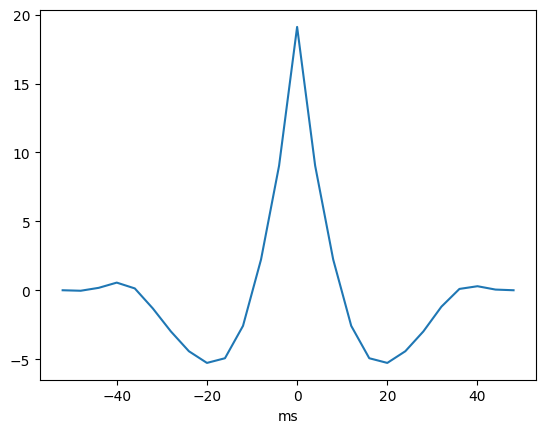

In [27]:
df_100_20_Z_4898_5092 = pd.read_csv('data/wav_100_20_Z_4898_5092.dat', 
                           header = None, sep = '\t')
wav_100_20_Z_4898_5092 = df_100_20_Z_4898_5092[1].values
plt.plot(df_100_20_Z_4898_5092[0].values, wav_100_20_Z_4898_5092); plt.xlabel('ms');
wav_100_20_Z_4898_5092.shape

In [28]:
wvlt = wav_100_20_Z_4898_5092

# read

In [29]:
seis = V3D.data
seis.shape

(176, 399, 49)

In [30]:
phi_max = np.max(x_trn) #can also take 1 or critical porosity (0.4)
phi_min = np.min(x_trn) #can also take 0
denom_phi = np.mean(x_trn)
np.save('output/denom_phi.npy', denom_phi)
phi_max, phi_min, denom_phi

(0.37750762000000004, 0.008589827, 0.11332465650034577)

In [31]:
seis_normalized = (seis - np.min(seis)) / (np.max(seis) - np.min(seis))

# X_train, X_test = sklearn.model_selection.train_test_split(seis_normalized, test_size = 0.2, random_state = 1)
X_train = np.array(seis[:split, :, :]).reshape(-1, seis.shape[-1])
X_test = np.array(seis[split:, :, :]).reshape(-1, seis.shape[-1])

X_train_final = np.expand_dims(np.expand_dims(X_train, axis=1), axis=3)
X_test_final = np.expand_dims(np.expand_dims(X_test, axis=1), axis=3)

print ("number of training examples = " + str(X_train_final.shape[0]))
print ("number of test examples = " + str(X_test_final.shape[0]))
print ("X_train shape: " + str(X_train_final.shape))
print ("X_test shape: " + str(X_test_final.shape))

number of training examples = 55860
number of test examples = 14364
X_train shape: (55860, 1, 49, 1)
X_test shape: (14364, 1, 49, 1)


In [32]:
denom_seis = tf.reduce_mean(X_train)
np.save('output/denom_seis.npy', denom_seis)
denom_seis

<tf.Tensor: shape=(), dtype=float32, numpy=-0.005115529>

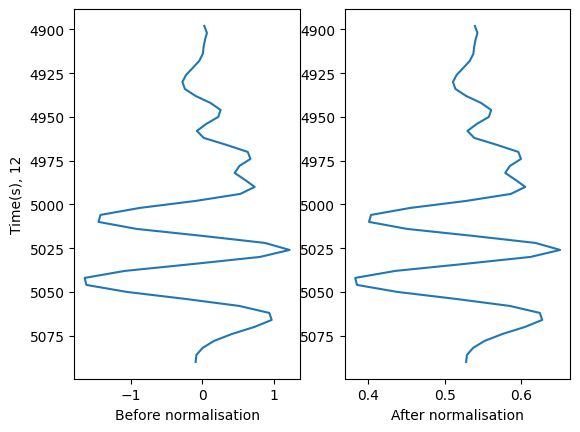

In [33]:
time_upscaled = V3D.twt.values
i = np.random.choice(seis.shape[0], size = 1)[0]

plt.subplot(1,2,1);
plt.plot(np.squeeze(seis[i, 0, :]), time_upscaled);
plt.gca().invert_yaxis();
plt.ylabel('Time(s), {}'.format(i));
plt.xlabel('Before normalisation');

plt.subplot(1,2,2);
plt.plot(np.squeeze(seis_normalized[i, 0, :]), time_upscaled);
plt.gca().invert_yaxis();
plt.xlabel('After normalisation');

# model

In [34]:
class Linear1D(Layer):
    def __init__(self):
        super().__init__()
        # self.beta1 = self.add_weight(shape = (1, 1), initializer = initializers.Constant(regr_lr.coef_[0]), trainable = True, name = 'beta1')
        # self.beta0 = self.add_weight(shape = (1), initializer = initializers.Constant(regr_lr.intercept_[0]), trainable = True, name = 'beta0')
        # self.beta1 = self.add_weight(shape = (1, 1), initializer = 'random_normal', trainable = True, name = 'beta1')
        # self.beta0 = self.add_weight(shape = (1, 1), initializer = 'random_normal', trainable = True, name = 'beta0')
        self.beta1 = self.add_weight(shape = (1, 1), initializer = initializers.Constant(-21.72), trainable = True, name = 'beta1')
        self.beta0 = self.add_weight(shape = (1, 1), initializer = initializers.Constant(15.13), trainable = True, name = 'beta0')
    
    def call(self, inputs):
        # return inputs * self.beta1 + self.beta0
        return tf.math.multiply(inputs, self.beta1) + self.beta0
        # return tf.math.multiply(inputs, self.beta1 * 10) + self.beta0 * 10

In [35]:
given_seed = 2

input_final = Input(shape=(X_train_final.shape[1:]))

# Encoder
#1
X = Conv2D(32, (1, 3), strides=(1, 2), name='conv0', padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(input_final)

#X = BatchNormalization(axis=-1, name='bn0')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv0')(X)

#2
X = Conv2D(64, (1, 7), strides=(1, 2), name='conv1',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

#X = BatchNormalization(axis=-1, name='bn1')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv1')(X)

#3
X = Conv2D(128, (1, 15), strides=(1, 2), name='conv2',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

#X = BatchNormalization(axis=-1, name='bn2')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv2')(X)

#4 
X = Conv2D(256, (1, 30), strides=(1, 2), name='conv3',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)
          
#X = BatchNormalization(axis=-1, name='bn3')(X)
X = Activation('relu')(X)
X = Dropout(rate=0.3, name='drop_conv3')(X)

# FLATTEN X + FULLYCONNECTED
X = Flatten()(X)
    
X = Dense(seis.shape[-1], name='fc0',
          kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

encoded = Activation('tanh')(X) ##to scale the output between –1 and 1 before passing it as input to the decoder

# Decoder
encoded = tf.cast(encoded, tf.float64)

phi_for = ((encoded + 1) / 2) ##scaled between 0 and 1

phi = phi_for * (phi_max - phi_min) + phi_min + 1e-07

impedance_time = Linear1D()(phi)

impedance_time = tf.cast(impedance_time, tf.float64)

# Rpp_0 = RC_fwd_model(Vp_time[:,0:-1], RHO_time[:,0:-1], Vp_time[:,1:], RHO_time[:,1:])
Rpp_0 = RC_fwd_model_ia(impedance_time[:,0:-1], impedance_time[:,1:])
# Rpplast = 0.0 / (Vp_time[:,0])
Rpplast = 0.0 / (impedance_time[:,0])
Rpp0 = tf.concat([Rpp_0, tf.expand_dims(Rpplast, axis=1)], axis=1)

kernel_wvlt = tf.reshape(wvlt, [int(wvlt.shape[0]), 1, 1])
RC0 = tf.expand_dims(Rpp0, axis=2)
seis_for0 = tf.squeeze(tf.nn.conv1d(RC0, tf.reverse(kernel_wvlt,[0]), 1,'SAME'),axis=2)
    
seis_for_normalized = (seis_for0 - np.min(seis))/(np.max(seis)-np.min(seis))

seis_for_final = tf.concat([seis_for_normalized],axis=1)

In [36]:
impedance_time.shape, Rpp_0.shape, Rpplast.shape, Rpp0.shape

(TensorShape([None, 49]),
 TensorShape([None, 48]),
 TensorShape([None]),
 TensorShape([None, 49]))

In [37]:
kernel_wvlt.shape, RC0.shape

(TensorShape([26, 1, 1]), TensorShape([None, 49, 1]))

In [38]:
rw_pinn = Model(inputs = input_final, outputs = seis_for_final)
rw_pinn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 49, 1)]   0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 1, 25, 32)    128         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 1, 25, 32)    0           conv0[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1, 13, 64)    14400       activation[0][0]                 
______________________________________________________________________________________________

# train

In [39]:
class loss_func(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        mse_seis1 = tf.reduce_mean(tf.square(y_pred[:,0:246] - y_true[:,0:246]))
        
        return tf.math.sqrt(mse_seis1)

In [40]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
rw_pinn.compile(loss = loss_func(), optimizer = adam)

In [41]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('output/rwpinn_model.h5', monitor='val_loss', mode='min', verbose=1, save_weights_only=True)

In [ ]:
# Start the training

Batch_size = 128
history = rw_pinn.fit(X_train_final, X_train, 
                      validation_split=0.2, epochs=20, 
                      batch_size=Batch_size, callbacks=[es, mc], verbose = 1)

Epoch 1/200
350/350 [==============================] - 84s 238ms/step - loss: 0.7318 - val_loss: 0.7920

Epoch 00001: saving model to output\rwpinn_model.h5
Epoch 2/200
350/350 [==============================] - 121s 345ms/step - loss: 0.7026 - val_loss: 0.7815

Epoch 00002: saving model to output\rwpinn_model.h5
Epoch 3/200
350/350 [==============================] - 129s 370ms/step - loss: 0.6933 - val_loss: 0.7703

Epoch 00003: saving model to output\rwpinn_model.h5
Epoch 4/200
350/350 [==============================] - 115s 328ms/step - loss: 0.6825 - val_loss: 0.7588

Epoch 00004: saving model to output\rwpinn_model.h5
Epoch 5/200
350/350 [==============================] - 75s 213ms/step - loss: 0.6753 - val_loss: 0.7457

Epoch 00005: saving model to output\rwpinn_model.h5
Epoch 6/200
350/350 [==============================] - 77s 219ms/step - loss: 0.6651 - val_loss: 0.7316

Epoch 00006: saving model to output\rwpinn_model.h5
Epoch 7/200
350/350 [==============================] - 

KeyboardInterrupt: 

# eval

In [47]:
# load the saved model
# rw_pinn.load_weights('output/rwpinn_model.h5')
rw_pinn.load_weights('output/rwpinn_model_fix20.h5')

## loss

In [90]:
# Testing and evaluating the model
Batch_size = 128
preds = rw_pinn.evaluate(X_test_final, X_test, batch_size=Batch_size, verbose=0, sample_weight=None)
print("Loss = " + str(preds))

Loss = 0.5369429588317871


In [ ]:
# Plotting the learning curve 
plt.plot(history.history['loss']/np.max(history.history['loss']));
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']));

#plt.title('Learning curve')
plt.ylabel('Normalized Loss');
plt.xlabel('Epochs');
plt.legend(['Training loss', 'Validation loss'], loc='upper right');

# plt.ylim([0.05, 0.2]);

## trn tst

In [43]:
## Only the Encoder part
rw_pinn_encoder = Model(inputs=input_final, outputs=encoded)

In [44]:
encoder_output_trainset = rw_pinn_encoder.predict(X_train_final)
phi_trainset_pred = ((encoder_output_trainset+1)/2) * (phi_max - phi_min) + phi_min
encoder_output_testset = rw_pinn_encoder.predict(X_test_final)
phi_testset_pred = ((encoder_output_testset+1)/2) * (phi_max - phi_min) + phi_min

decoder_output_trainset = rw_pinn.predict(X_train_final)
seis_output_trainset = decoder_output_trainset
decoder_output_testset = rw_pinn.predict(X_test_final)
seis_output_testset = decoder_output_testset

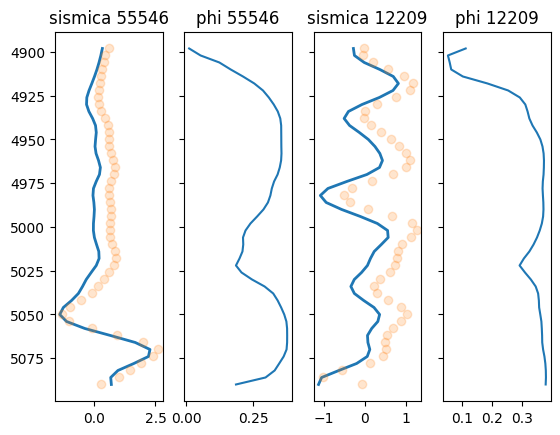

In [52]:
fig, axs = plt.subplots(1, 4, sharey=True);

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(np.squeeze(X_train_final[i,:,:]),time_upscaled,linewidth=2,label='True');
axs[0].plot(seis_output_trainset[i,:],time_upscaled,'o',alpha=0.2,label='Predicted');
axs[0].set_title('sismica {}'.format(i));

axs[1].plot(phi_trainset_pred[i, :], time_upscaled);
axs[1].set_title('phi {}'.format(i));

j = np.random.choice(X_test_final.shape[0], size = 1)[0]
axs[2].plot(np.squeeze(X_test_final[21,:,:]),time_upscaled,linewidth=2);
axs[2].plot(seis_output_testset[21,:],time_upscaled,'o',alpha=0.2);
axs[2].set_title('sismica {}'.format(j));

axs[3].plot(phi_testset_pred[j, :], time_upscaled);
axs[3].set_title('phi {}'.format(j));

# fig.supxlabel('Porosity(V/V)');
# fig.supylabel('Depth(m)');
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower left');

plt.gca().invert_yaxis();

## well

In [45]:
idx3 = (twt3 > depth_point1) * (twt3 < depth_point2)
idx5 = (twt5 > depth_point1) * (twt5 < depth_point2)
idx8 = (twt8 > depth_point1) * (twt8 < depth_point2)
idx12 = (twt12 > depth_point1) * (twt12 < depth_point2)
idx14 = (twt14 > depth_point1) * (twt14 < depth_point2)
idx18 = (twt18 > depth_point1) * (twt18 < depth_point2)

### well 3 7buz23rjs

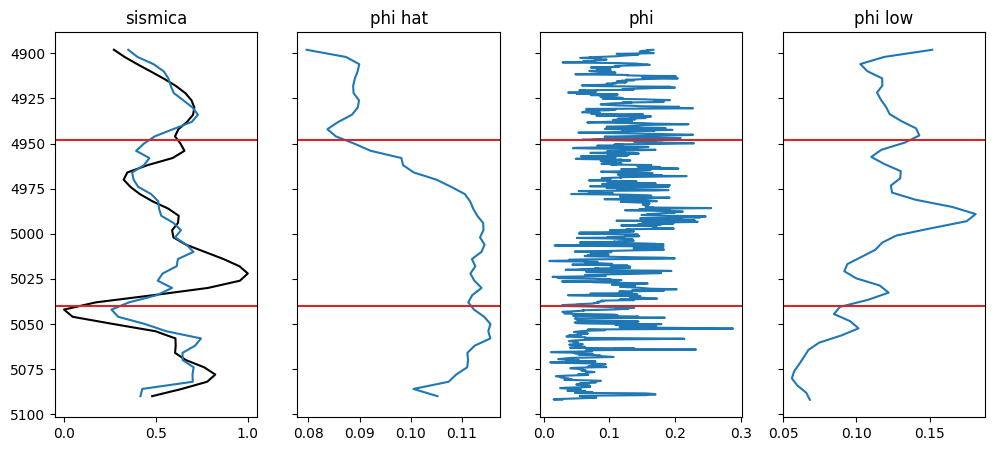

In [49]:
sismica = sismica3
phi = phi3
idx = idx3
twt = twt3

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(sample, time_upscaled, color = "black", label='true');
axs[0].plot(decoder_output_sample[0, :], time_upscaled, label='predicted');
axs[0].set_title('sismica');

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

zz = np.linspace(depth_point1, depth_point2, len(phi[idx]))
axs[2].plot(phi[idx], zz, label = 'predicted');
axs[2].set_title('phi');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[3].plot(philow, zz, label = 'predicted');
axs[3].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

### well 5 7-buz-29-rjs

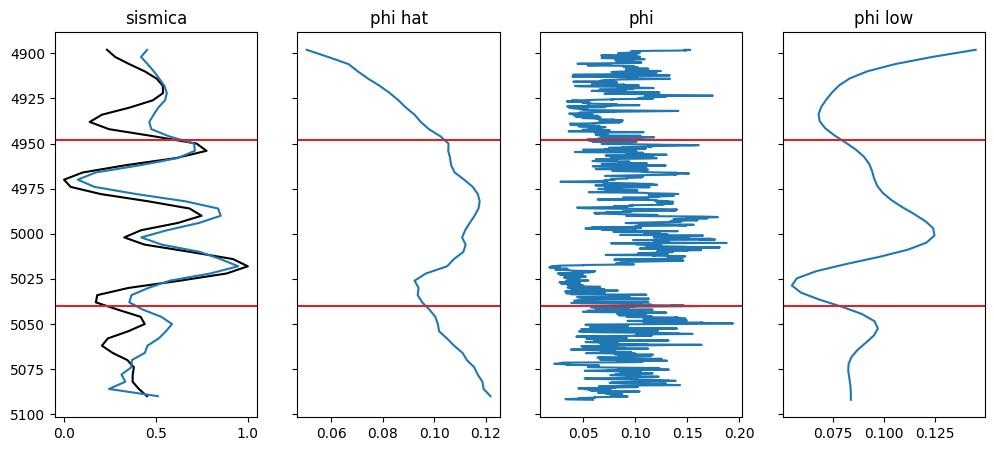

In [50]:
sismica = sismica5
phi = phi5
idx = idx5
twt = twt5

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(sample, time_upscaled, color = "black", label='true');
axs[0].plot(decoder_output_sample[0, :], time_upscaled, label='predicted');
axs[0].set_title('sismica');

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

zz = np.linspace(depth_point1, depth_point2, len(phi[idx]))
axs[2].plot(phi[idx], zz, label = 'predicted');
axs[2].set_title('phi');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[3].plot(philow, zz, label = 'predicted');
axs[3].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

### well 8 8-buz-26-rjs

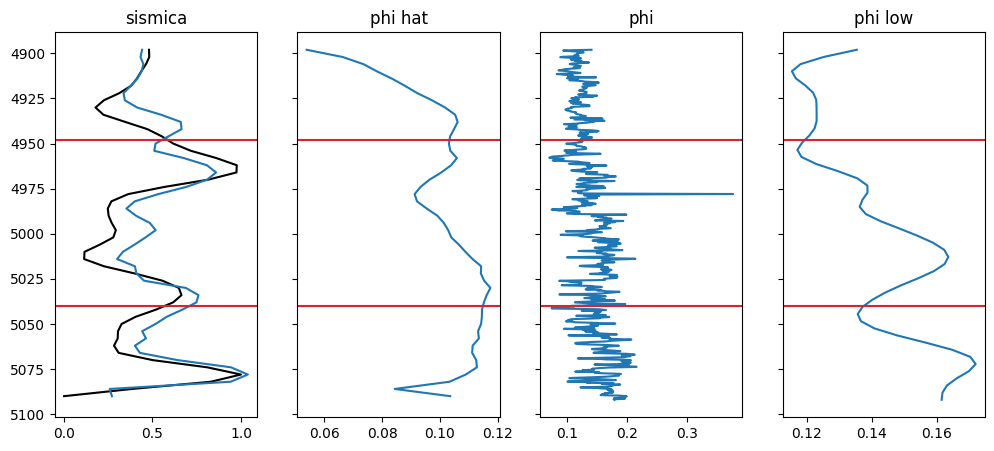

In [51]:
sismica = sismica8
phi = phi8
idx = idx8
twt = twt8

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(sample, time_upscaled, color = "black", label='true');
axs[0].plot(decoder_output_sample[0, :], time_upscaled, label='predicted');
axs[0].set_title('sismica');

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

zz = np.linspace(depth_point1, depth_point2, len(phi[idx]))
axs[2].plot(phi[idx], zz, label = 'predicted');
axs[2].set_title('phi');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[3].plot(philow, zz, label = 'predicted');
axs[3].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

### well 12 8buz20rjs

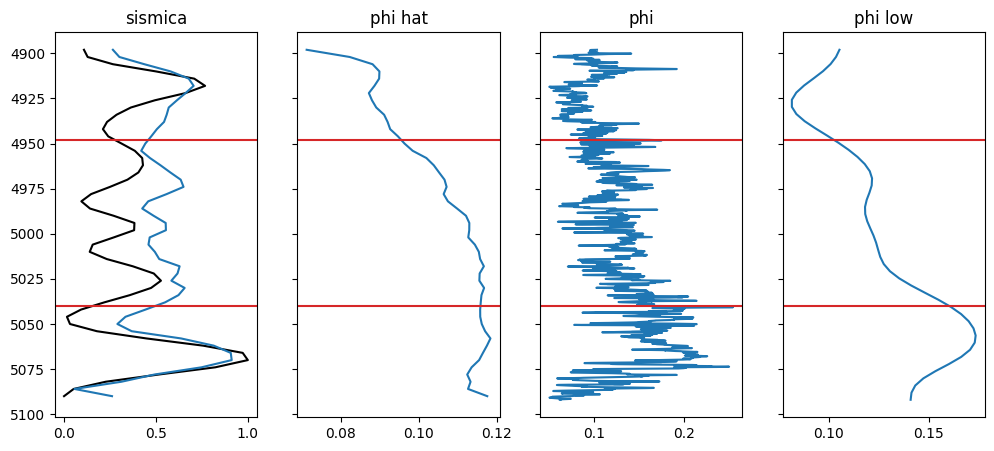

In [54]:
sismica = sismica12
phi = phi12
idx = idx12
twt = twt12

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(sample, time_upscaled, color = "black", label='true');
axs[0].plot(decoder_output_sample[0, :], time_upscaled, label='predicted');
axs[0].set_title('sismica');

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

zz = np.linspace(depth_point1, depth_point2, len(phi[idx]))
axs[2].plot(phi[idx], zz, label = 'predicted');
axs[2].set_title('phi');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[3].plot(philow, zz, label = 'predicted');
axs[3].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

### well 14 7-buz-10-rjs

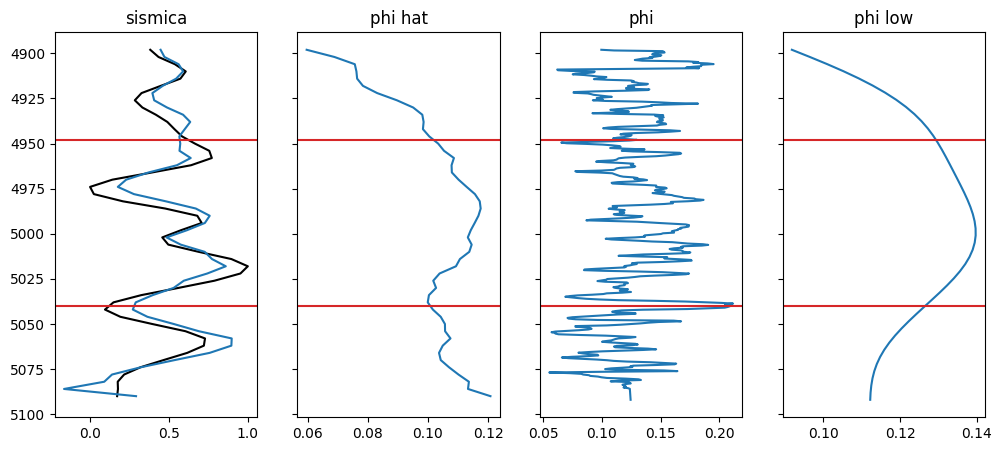

In [55]:
sismica = sismica14
phi = phi14
idx = idx14
twt = twt14

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(sample, time_upscaled, color = "black", label='true');
axs[0].plot(decoder_output_sample[0, :], time_upscaled, label='predicted');
axs[0].set_title('sismica');

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

zz = np.linspace(depth_point1, depth_point2, len(phi[idx]))
axs[2].plot(phi[idx], zz, label = 'predicted');
axs[2].set_title('phi');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[3].plot(philow, zz, label = 'predicted');
axs[3].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

### well 18 3-brsa-1053-rjs

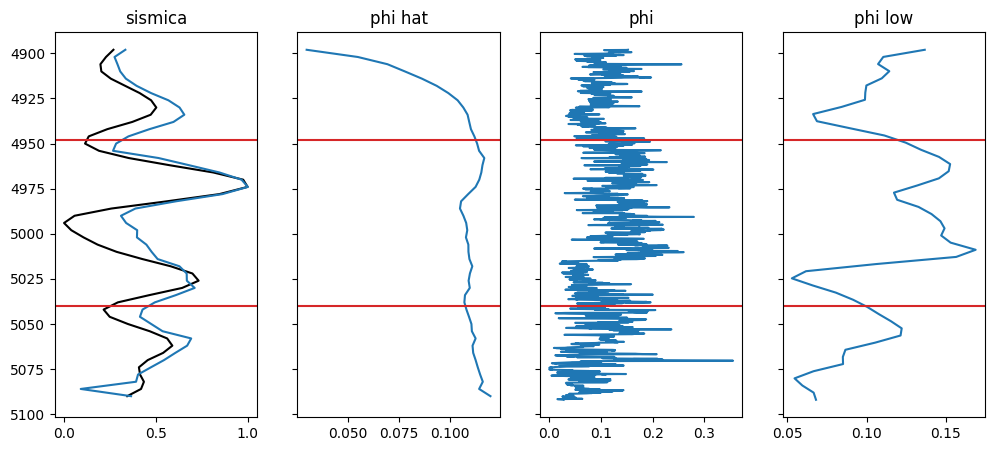

In [56]:
sismica = sismica18
phi = phi18
idx = idx18
twt = twt18

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
axs[0].plot(sample, time_upscaled, color = "black", label='true');
axs[0].plot(decoder_output_sample[0, :], time_upscaled, label='predicted');
axs[0].set_title('sismica');

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

zz = np.linspace(depth_point1, depth_point2, len(phi[idx]))
axs[2].plot(phi[idx], zz, label = 'predicted');
axs[2].set_title('phi');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[3].plot(philow, zz, label = 'predicted');
axs[3].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

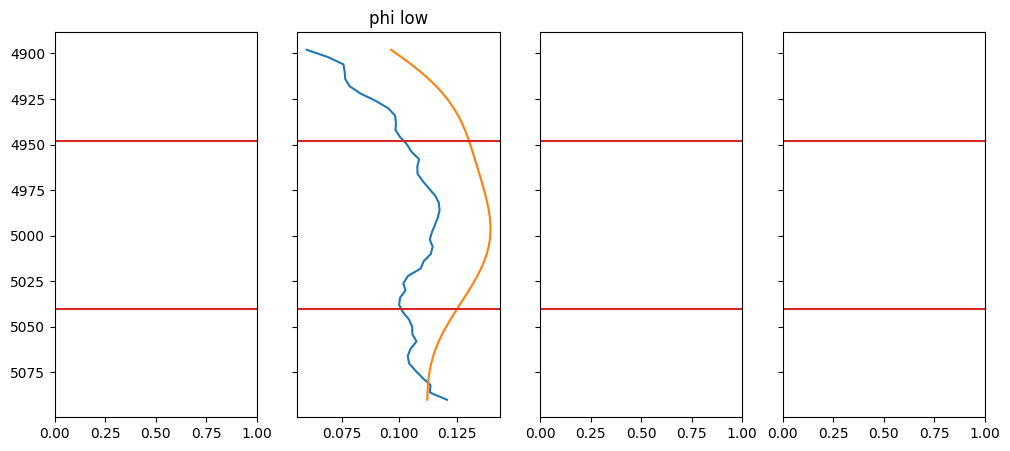

In [ ]:
sismica = sismica5
phi = phi5
idx = idx5
twt = twt14

sample = (sismica - np.min(sismica)) / (np.max(sismica) - np.min(sismica))
sample_normalized = sample.reshape(1, 1, -1, 1)

encoder_output_sample = rw_pinn_encoder.predict(sample_normalized)
phi_sample_pred = ((encoder_output_sample+1)/2) * (phi_max - phi_min) + phi_min
decoder_output_sample = rw_pinn.predict(sample_normalized)

fig, axs = plt.subplots(1, 4, sharey=True, figsize = (12, 5));

axs[1].plot(phi_sample_pred[0, :] / 3, time_upscaled, label = 'predicted');
axs[1].set_title('phi hat');

philow = escala_sismica(twt[idx], phi[idx], np.array(V3D.data), depth_point1, depth_point2)
# zz = np.linspace(depth_point1, depth_point2, len(philow))
axs[1].plot(philow[1:], time_upscaled, label = 'predicted');
axs[1].set_title('phi low');

[axs[i].axhline(y = depth_point1true, color = 'tab:red') for i in range(4)];
[axs[i].axhline(y = depth_point2true, color = 'tab:red') for i in range(4)];
plt.gca().invert_yaxis();

(i) usar um poço (semi supervised)

(ii) montar ppt (terça)

(ix) tensorflow -> pytorch

(x) fazer na porosidade (funçao ativaçao)